# NLTK Chapter 1

## Accessing Text Corpora and Lexical Resources

*The html version of this chapter in the NLTK book is available [here](https://www.nltk.org/book/ch02.html#exercises "Ch02 Exercises").*

### 8   Exercises

###### 1. 

☼ Create a variable `phrase` containing a list of words. Review the operations described in the previous chapter, including addition, multiplication, indexing, slicing, and sorting..

In [3]:
phrase1 = ['This', 'is', 'a', 'lovely', 'list', 'of', 'words.']
phrase2 = ['As', 'is', 'this.']

phrase1 + phrase2

In [6]:
print(phrase1 * 3, end = '')

['This', 'is', 'a', 'lovely', 'list', 'of', 'words.', 'This', 'is', 'a', 'lovely', 'list', 'of', 'words.', 'This', 'is', 'a', 'lovely', 'list', 'of', 'words.']

In [8]:
phrase1[-1]

'words.'

In [7]:
phrase1[2:]

['a', 'lovely', 'list', 'of', 'words.']

In [11]:
sorted(phrase1 + phrase2)

['As', 'This', 'a', 'is', 'is', 'list', 'lovely', 'of', 'this.', 'words.']

###### 2.

☼ Use the corpus module to explore `austen-persuasion.txt`. How many word tokens does this book have? How many word types?

*As I discussed at length in my notes, I recommend removing non-alphabetic characters and enclitics:*

In [16]:
from nltk.corpus import gutenberg

austen = 'austen-persuasion.txt'
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")
words = gutenberg.words(austen)

# number of tokens
num_tokens = len([w for w in words if w.isalpha() and w not in enclitics])

num_tokens

83617

In [17]:
# number of word types
num_wt = len(set([w for w in words if w.isalpha() and w not in enclitics]))
num_wt

6031

*If we didn't bother with removing non-alphabetic characters and enclitics:*

In [18]:
# number of tokens
num_tokens = len([w for w in words])

num_tokens

98171

In [19]:
# number of word types
num_wt = len(set([w for w in words]))
num_wt

6132

###### 3. 

☼ Use the Brown corpus reader `nltk.corpus.brown.words()` or the Web text corpus reader `nltk.corpus.webtext.words()` to access some sample text in two different genres.

*The code below will randomly choose a category, and then randomly print five sentences from that category.*

In [105]:
from nltk.corpus import brown
import random

random_category = random.choice(brown.categories())
random_place = random.randint(0, len(brown.sents(categories = random_category)) - 5)


print(brown.sents(categories = random_category)[random_place:random_place + 5], end = '')

[['The', 'radio', 'radiation', 'of', 'the', 'sun', 'which', 'is', 'reflected', 'from', 'the', 'moon', 'and', 'planets', 'should', 'be', 'negligible', 'compared', 'with', 'their', 'thermal', 'emission', 'at', 'centimeter', 'wave', 'lengths', ',', 'except', 'possibly', 'at', 'times', 'of', 'exceptional', 'outbursts', 'of', 'solar', 'radio', 'noise', '.'], ['The', 'quiescent', 'level', 'of', 'centimeter', 'wave-length', 'solar', 'radiation', 'would', 'increase', 'the', 'average', 'disk', 'brightness', 'temperature', 'by', 'less', 'than', '1-degree', '.'], ['At', 'meter', 'wave', 'lengths', 'an', 'increase', 'of', 'the', 'order', 'of', '10-degrees', 'in', 'the', 'average', 'disk', 'temperatures', 'of', 'the', 'nearer', 'planets', 'would', 'be', 'expected', '.'], ['Therefore', ',', 'neglecting', 'the', 'extreme', 'outbursts', ',', 'reflected', 'solar', 'radiation', 'is', 'not', 'expected', 'to', 'cause', 'sizable', 'errors', 'in', 'the', 'measurements', 'of', 'planetary', 'radiation', 'in',

*As you can see, the output doesn't look very nice.  We could try a list comprehension:*

In [106]:
print([w for w in brown.sents(categories = random_category)[random_place:random_place + 5]], end = '')

[['The', 'radio', 'radiation', 'of', 'the', 'sun', 'which', 'is', 'reflected', 'from', 'the', 'moon', 'and', 'planets', 'should', 'be', 'negligible', 'compared', 'with', 'their', 'thermal', 'emission', 'at', 'centimeter', 'wave', 'lengths', ',', 'except', 'possibly', 'at', 'times', 'of', 'exceptional', 'outbursts', 'of', 'solar', 'radio', 'noise', '.'], ['The', 'quiescent', 'level', 'of', 'centimeter', 'wave-length', 'solar', 'radiation', 'would', 'increase', 'the', 'average', 'disk', 'brightness', 'temperature', 'by', 'less', 'than', '1-degree', '.'], ['At', 'meter', 'wave', 'lengths', 'an', 'increase', 'of', 'the', 'order', 'of', '10-degrees', 'in', 'the', 'average', 'disk', 'temperatures', 'of', 'the', 'nearer', 'planets', 'would', 'be', 'expected', '.'], ['Therefore', ',', 'neglecting', 'the', 'extreme', 'outbursts', ',', 'reflected', 'solar', 'radiation', 'is', 'not', 'expected', 'to', 'cause', 'sizable', 'errors', 'in', 'the', 'measurements', 'of', 'planetary', 'radiation', 'in',

*That doesn't help much.  I seem to recall having this problem in Chapter 1, so I believe I'll place the code I used into a function.  Before we do that, we'll use list comprehension to get a list of punctuation saved as word types in the Brown Corpus.*

In [151]:
non_alpha = sorted(set([y for y in [c for w in brown.sents() for c in w if len(c) == 1] if not y.isalnum()]))

non_alpha

['!', '&', "'", '(', ')', '+', ',', '-', '.', '/', ':', ';', '?', '[', ']']

In [179]:
def convert_list_to_text(l, exclude = []):
    full_sent = ""
    alpha_text = []
    
    for i in range(len(l)):

        if l[i] not in exclude:
            alpha_text.append(l[i])
        
        # Don't need spaces after brackets
        elif l[i] == "(" or l[i] == "[" or l[i] == "&" or l[i] == "`":
            full_sent += (' '.join(alpha_text) + ' ' + l[i])
            alpha_text = []

        # May need spaces after brackets
        elif l[i] == ")" or l[i] == "]":
            # Need spaces if the next item is a word
            if i + 1 < len(l):
                if l[i + 1] not in exclude:
                    full_sent += (' '.join(alpha_text) + l[i] + ' ')
            # Don't need spaces before punctuation
            else:
                full_sent += (' '.join(alpha_text) + l[i])
                alpha_text = []
        else:
            full_sent += (' '.join(alpha_text) + l[i] + ' ')
            alpha_text = []

    return full_sent

In [162]:
text = [w for w in brown.sents(categories = random_category)[random_place:random_place + 5]]

full_text = []
for t in text:
    full_text.append(convert_list_to_text(t, non_alpha))
print(''.join(full_text))

`` It doesn't drown out the dialogue '', I explained. `` Let's talk about books '', Moreland said. `` I am told that in America you have non-books by non-writers, brought out by non-publishers for non-readers. Is it all non-fiction ''? ? `` There is non-fiction and non non-fiction '', I said. 


*It's not perfect, but it looks much better than it did.  Let's try it again with another random text:*

In [186]:
random_category = random.choice(brown.categories())
random_place = random.randint(0, len(brown.sents(categories = random_category)) - 5)

text = [w for w in brown.sents(categories = random_category)[random_place:random_place + 5]]

full_text = []
for t in text:
    full_text.append(convert_list_to_text(t, non_alpha))
print(''.join(full_text))

The daughter replied, `` Oh, I had dinner with -- well, you don't know him but he's awfully nice -- and we went to a couple of places -- I don't suppose you've heard of them -- and we finished up at a cute little night club -- I forget the name of it. Why, it's all right, isn't it, Mother ''? ? Her woolly-minded parent agreed. `` Of course, dear '', she said. `` It's only that I like to know where you go ''. 


*There are still some issues with spaces being inserted before and after quotation marks.  I'll have to come back to this later, as I've already spent too much time on this question...*

###### 4.
☼ Read in the texts of the State of the Union addresses, using the `state_union` corpus reader. Count occurrences of `men`, `women`, and `people` in each document. What has happened to the usage of these words over time?

In [103]:
import nltk
%matplotlib inline
from nltk.corpus import state_union

In [192]:
cfd = nltk.ConditionalFreqDist(
        (target, fileid[:4])
        for fileid in state_union.fileids()
        for w in state_union.words(fileid)
        for target in ['men', 'women', 'people']
        if w.lower().startswith(target))

*There are too many documents here for us to put them in a table that will fit across the screen:*

In [215]:

len(state_union.fileids())

65

*One option to deal with this is to use a sampling of one State of the Union from every four years.  This way, there will be approximately one address for each presidential term:*

In [214]:
years = range(1945, 2007, 4)
cfd.tabulate(samples = [str(y) for y in years], conditions = ['men', 'women', 'people'])

       1945 1949 1953 1957 1961 1965 1969 1973 1977 1981 1985 1989 1993 1997 2001 2005 
   men    2    2    5    7    6   22    5    1    2    3    1    4    1    1    6    8 
 women    2    1    0    2    0    3    2    0    1    1    1    3    2    2    6   11 
people   10   18   20   17   13   30    6   10   20   11   12   13   45   31   27   18 


*Another option is to use a plot instead of a table:*

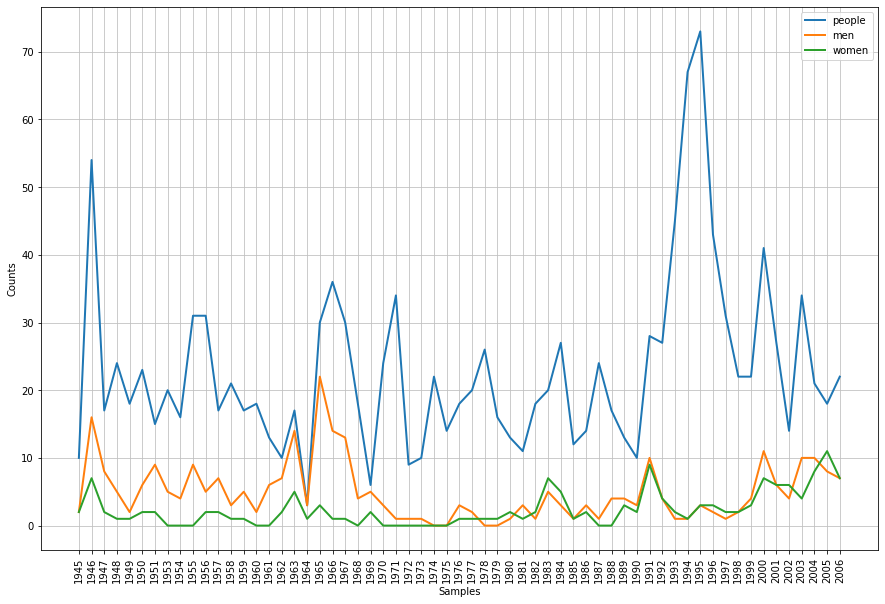

In [198]:
# to adjust the size of the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
cfd.plot();

###### 5.

☼ Investigate the holonym-meronym relations for some nouns. Remember that there are three kinds of holonym-meronym relation, so you need to use: `member_meronyms()`, `part_meronyms()`, `substance_meronyms()`, `member_holonyms()`, `part_holonyms()`, and `substance_holonyms()`.

*As I mentioned in my notes for Chapter 2, I've found WordNet to be quite difficult to navigate.  The work that I've done on this unit has done nothing to convince me otherwise.  In addition to being difficult to use, I'm finding WordNet rather incomplete.  Let me take 'school' as an example.  Since I'm not sure which synset corresponds to the traditional meaning of 'school', I'll look up the definitions.*

In [197]:
from nltk.corpus import wordnet as wn

In [234]:
[s.definition() for s in wn.synsets('school')]

['an educational institution',
 'a building where young people receive education',
 'the process of being formally educated at a school',
 'a body of creative artists or writers or thinkers linked by a similar style or by similar teachers',
 'the period of instruction in a school; the time period when school is in session',
 "an educational institution's faculty and students",
 'a large group of fish',
 'educate in or as if in a school',
 'teach or refine to be discriminative in taste or judgment',
 'swim in or form a large group of fish']

In [244]:
wn.synset('school.n.01').member_meronyms()

[Synset('schoolteacher.n.01'), Synset('staff.n.03')]

*Of course, a school needs teachers, as well as staff.  But doesn't it seem odd that it's lacking students?  Let's try another example: 'team'.*

In [242]:
[s.definition() for s in wn.synsets('team')]

['a cooperative unit (especially in sports)',
 'two or more draft animals that work together to pull something',
 'form a team']

In [241]:
wn.synset('team.n.01').member_meronyms()

[Synset('stringer.n.01')]

*So, "stringer"s are more essential to teams than players?  Interesting...*

In [243]:
wn.synset('team.n.01').part_meronyms()

[Synset('bench.n.06')]

In [237]:
wn.synset('school.n.02').part_meronyms()

[Synset('classroom.n.01')]

*I'm not too surprised that 'school's and 'team's don't have substances, but it was rather difficult to come up with non-chemical examples.*

In [240]:
wn.synset('water.n.01').substance_meronyms()

[Synset('hydrogen.n.01'), Synset('oxygen.n.01')]

*Blood is made from serum?  Fascinating...*

In [250]:
wn.synset('blood.n.01').substance_meronyms()

[Synset('serum.n.01')]

*Let's go the other way and see if we have more luck:*

In [251]:
[s.definition() for s in wn.synsets('player')]

['a person who participates in or is skilled at some game',
 'someone who plays a musical instrument (as a profession)',
 'a theatrical performer',
 'a person who pursues a number of different social and sexual partners simultaneously',
 'an important participant (as in a business deal)']

In [253]:
wn.synset('player.n.01').member_holonyms()

[]

In [257]:
wn.synset('player.n.01').part_holonyms()

[]

*Interesting - let's see if `member` is a member of any holonyms:*

In [254]:
[s.definition() for s in wn.synsets('member')]

['one of the persons who compose a social group (especially individuals who have joined and participate in a group organization)',
 'anything that belongs to a set or class',
 'an external body part that projects from the body',
 'an organization that is a member of another organization (especially a state that belongs to a group of nations)',
 "the male organ of copulation (`member' is a euphemism)"]

In [255]:
wn.synset('member.n.01').member_holonyms()

[]

In [256]:
wn.synset('member.n.01').part_holonyms()

[]

*Amazing.  The maintainers of WordNet found it necessary to remark that 'member' can be slang for a penis, but not that 'member' can be, well, a member of anything.*

*Let's keep on trying.  After about five tries, I finally found a word that had a `part_holonym`:*

In [266]:
wn.synset('wing.n.01').part_holonyms()

[Synset('angel.n.01'),
 Synset('bat.n.01'),
 Synset('bird.n.01'),
 Synset('insect.n.01')]

*Likewise, I needed about five tries to find a word that had a `member_holonym`:*

In [278]:
wn.synset('animal.n.01').member_holonyms()

[Synset('animalia.n.01')]

In [280]:
wn.synset('bird.n.01').member_holonyms()

[Synset('aves.n.01'), Synset('flock.n.02')]

*But it was easier to find a __substance holonym__ than __substance meronym__.*

In [281]:
wn.synset('water.n.01').substance_holonyms()

[Synset('body_of_water.n.01'),
 Synset('ice.n.01'),
 Synset('ice_crystal.n.01'),
 Synset('perspiration.n.01'),
 Synset('snowflake.n.01'),
 Synset('tear.n.01')]

*My feelings from earlier are if anything stronger than before: WordNet is too incomplete and too inconsistent to be of any practical use.*

###### 6.

☼ In the discussion of comparative wordlists, we created an object called `translate` which you could look up using words in both German and Spanish in order to get corresponding words in English. What problem might arise with this approach? Can you suggest a way to avoid this problem?

*One issue might be homographs with different meanings.  I.e., a word that is spelled the same in both languages, but has different meanings.  A possible fix would be to add a second parameter to `translate` which would specify from which dictionary the translation should be drawn.*

###### 7. 

☼ According to Strunk and White's Elements of Style, the word however, used at the start of a sentence, means "in whatever way" or "to whatever extent", and not "nevertheless". They give this example of correct usage: <i>[However you advise him, he will probably do as he thinks best.]( http://www.bartleby.com/141/strunk3.html "'However' example")</i> Use the concordance tool to study actual usage of this word in the various texts we have been considering. See also [the LanguageLog posting "Fossilized prejudices about 'however'"](http://itre.cis.upenn.edu/~myl/languagelog/archives/001913.html "Fossilized prejudices about 'however'").

*One issue with NLTK's concordance tool is that it doesn't allow us to specify where in the sentence the word should be found.  In the first 25 occurences of 'however' in "Emma", only three occur at the start of a sentence:*

In [101]:
emma = nltk.Text(nltk.corpus.gutenberg.words('austen-emma.txt'))
emma.concordance("However")

Displaying 25 of 131 matches:
 her many enjoyments . The danger , however , was at present so unperceived , t
ion would offend . Miss Churchill , however , being of age , and with the full 
n . From the expense of the child , however , he was soon relieved . The boy ha
 -- and been very well brought up . However , I do not mean to set up my opinio
f and predict . It was not likely , however , that any body should have equalle
to be borne . We will not despair , however . Weston may grow cross from the wa
is so very handsome and agreeable . However , I do really think Mr . Martin a v
 accepted after all . This letter , however , was written , and sealed , and se
e him ." " And if I did , ( which , however , I am far from allowing ) I should
 slightingly . Waiving that point , however , and supposing her to be , as you 
e was not so materially cast down , however , but that a little time and the re
ld inspire him ." The very next day however produced some proof of inspiration 
and staid 

*To remedy this, I wrote this code, which prints out concordances only if a given word occurs at a specific point in a sentence:*

In [91]:
def find_concordance_by_position(text, word, pos = 0):
    """
    Returns a concordance for a text only if the word is
    found at the given position.  Works on lists where each
    item is a separate sentence.
    
    Arguments:
    
    text: The text to be searched.  Must be a list where
          each item is a separate sentence.
    word: The word to be searched for.  Case insensitive.
    pos:  The position where the word should be found.  
          Default is 0.
    """
    hits = 0
    
    for i in range(len(text)):
        if text[i][pos].lower() == word:
            prefix = text[i - 1]
            prefix = ' '.join(prefix)
            if len(prefix) < 35:
                prefix = (35 - len(prefix)) * " " + prefix
            suffix = text[i]
            suffix = ' '.join(suffix)
            print(prefix[-35:] + " " + suffix[:40])
            hits += 1
            
    if hits == 0:
        print("No matches.")

In [85]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('austen-emma.txt'), "however", 0)

 -- and been very well brought up . However , I do not mean to set up my opi
is so very handsome and agreeable . However , I do really think Mr . Martin 
eed !-- and my memory is very bad . However , it was an exceeding good , pre
          Jane speaks so distinct ! However , she will not find her grandmam
inctly , and was sadly alarmed at . However , when I read on , I found it wa
hough she speaks rather too quick . However , she is very agreeable , and Mr
at I would not expose any body to . However , as they are so very desirous t
ar , I did say as much as I could . However , the very same evening William 
m often astonished at what I hear . However , this does make a difference ; 
aks like you and poor Miss Taylor . However , she seems a very obliging , pr
emed very much to have enjoyed it . However , _I_ shall always think it a ve
t least , but I might be mistaken . However , I think it answered so far as 


*Older texts seem to use the word very infrequently, if at all:*

In [87]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('milton-paradise.txt'), 'however', 0)

f scorn , not to be given the Foe . However I with thee have fixed my lot , 
pride , and joy , for Man seduced . However , some tradition they dispersed 


In [92]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('bible-kjv.txt'), 'however', 0)


No matches.


In [93]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('shakespeare-hamlet.txt'), 'however', 0)


No matches.


*Now I'm going to look at the Brown Corpus, category by category;*

In [99]:
from nltk.corpus import brown

for c in brown.categories():
    print("Now analyzing {}: \n".format(c))

    find_concordance_by_position(brown.sents(categories = c), 'however', 0)
    
    print("\n")


Now analyzing adventure: 

ything but swarms of bees in them . However , when there's a job to be done 


Now analyzing belles_lettres: 

til well into the present century . However , in recent decades , for what d
absolutely certain of the answers . However , the system is designed , ingen
called `` historical monuments '' . However , just as all the buildings have
st and had even performed as such . However , when he assumed the duties of 
 dictates as faithfully as he can . However , there is always the possibilit
easurable properties of a command . However , for convenience we will stick 
 physiognomy of the Little People . However , it is important to trace the p
iritual forces into the situation . However , the crisis occurs precisely as
n that sense I can never be again . However , I confess my hope that I will 
may , like paradise , be regained . However , it was not of innocence in gen
mind and usage of Gentile and Jew . However , in the context of legal and ci
ling down on th

*I found only six instances where 'however' did not mean 'nevertheless' in the Brown Corpus, putting this usage in the absolute minority of usages. Methinks Strunk and White should have spent more time describing the language they heard and less prescribing how it should have been spoken.*

*This is an earlier version that looked at the words instead of the sentences.*

In [66]:
e = nltk.corpus.gutenberg.words('austen-emma.txt')
for i in range(len(e)):
    if e[i] == "However":
        prefix = []
        for word in e[i - 15 : i]:
            prefix.append(word)
        prefix = ' '.join(prefix)
        suffix = []
        for word in e[i : i + 15]:
            suffix.append(word)
        suffix = ' '.join(suffix)
        print(prefix[-35:] + " " + suffix[:40])

 -- and been very well brought up . However , I do not mean to set up my opi
is so very handsome and agreeable . However , I do really think Mr . Martin 
eed !-- and my memory is very bad . However , it was an exceeding good , pre
does me . Jane speaks so distinct ! However , she will not find her grandmam
inctly , and was sadly alarmed at . However , when I read on , I found it wa
hough she speaks rather too quick . However , she is very agreeable , and Mr
at I would not expose any body to . However , as they are so very desirous t
ar , I did say as much as I could . However , the very same evening William 
m often astonished at what I hear . However , this does make a difference ; 
aks like you and poor Miss Taylor . However , she seems a very obliging , pr
her , Mr . Suckling , in income .-- However , my resolution is taken as to n
forget her look the other night !-- However , I assure you , Miss Woodhouse 
y well ( blushing as she spoke ).-- However , now I will destroy it all -- a

###### 8. 

◑ Define a conditional frequency distribution over the Names corpus that allows you to see which *initial* letters are more frequent for males vs. females (cf. 4.4).

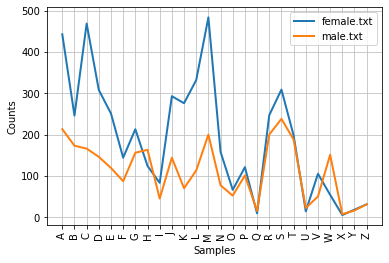

In [105]:
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

cfd = nltk.ConditionalFreqDist(
    (fileid, name[0])
    for fileid in names.fileids()
    for name in names.words(fileid))

cfd.plot();

###### 9.

◑ Pick a pair of texts and study the differences between them, in terms of vocabulary, vocabulary richness, genre, etc. Can you find pairs of words which have quite different meanings across the two texts, such as *monstrous* in *Moby Dick* and in *Sense and Sensibility*?

In [158]:
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")

print("King James' Bible:")
num_chars = len([w for w in gutenberg.raw('bible-kjv.txt') if w.isalpha()])
num_words = len([w for w in gutenberg.words('bible-kjv.txt') if w.isalpha() and w not in enclitics])
num_sents = len(gutenberg.sents('bible-kjv.txt'))
num_vocab = len(set(w.lower() for w in gutenberg.words('bible-kjv.txt') if w.isalpha() and w not in enclitics))
print("Average number of characters per word:", round(num_chars/num_words))
print("Average number of words per sent:",  round(num_words/num_sents))
print("Lexical diversity: {:.5f}".format(num_vocab/num_words))
print("Total tokens: {:,}".format(num_words))
print("Total word types: {:,}".format(num_vocab))

King James' Bible:
Average number of characters per word: 4
Average number of words per sent: 26
Lexical diversity: 0.01591
Total tokens: 790,052
Total word types: 12,567


In [157]:
nltk.Text(gutenberg.words('bible-kjv.txt')).concordance("cool")

Displaying 2 of 2 matches:
ORD God walking in the garden in the cool of the day : and Adam and his wife h
the tip of his finger in water , and cool my tongue ; for I am tormented in th


In [139]:
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")

print("'The Man Who Was Thursday' by G.K. Chesterton:")
num_chars = len([w for w in gutenberg.raw('chesterton-thursday.txt') if w.isalpha()])
num_words = len([w for w in gutenberg.words('chesterton-thursday.txt') if w.isalpha() and w not in enclitics])
num_sents = len(gutenberg.sents('chesterton-thursday.txt'))
num_vocab = len(set(w.lower() for w in gutenberg.words('chesterton-thursday.txt') if w.isalpha() and w not in enclitics))
print("Average number of characters per word:", round(num_chars/num_words))
print("Average number of words per sent:",  round(num_words/num_sents))
print("Lexical diversity: {:.5f}".format(num_vocab/num_words))
print("Total tokens: {:,}".format(num_words))
print("Total word types: {:,}".format(num_vocab))

'The Man Who Was Thursday' by G.K. Chesterton:
Average number of characters per word: 4
Average number of words per sent: 16
Lexical diversity: 0.10796
Total tokens: 58,297
Total word types: 6,294


In [155]:
nltk.Text(gutenberg.words('chesterton-thursday.txt')).concordance("cool")

Displaying 4 of 4 matches:
oke and pleasure out of pain . Yea , cool and clear and sudden as a bird sings
 " that you seem to have kept pretty cool under it . Now listen to me . I like
ok round . Syme , who was commonly a cool character , was literally gaping as 
in plunging into the wood they had a cool shock of shadow , as of divers who p


*I compared the King James' Bible and 'The Man Who Was Thursday' by G.K. Chesterton.  The bible is obviously a religious text, whereas Chesteron has been referred to as a mystery novel.  The bible is nearly 13 times as long and uses approximately twice as many words, but its lexical diversity is much lower, since the difference in length is not also reflected in the difference in vocabulary.  (It would be rare for a book to use much more than 10,000 word types, so in general, as texts get longer their lexical diversity will decrease.)*

*Since there aren't any newer texts in Project Gutenberg, it's difficult to compare texts to see changes in word usage over time.  However, we can find evidence that 'cool' changed in usage from merely describing temperature to also describing one's character.*

###### 10. 

◑ Read the [BBC News article: UK's Vicky Pollards 'left behind']( http://news.bbc.co.uk/2/hi/uk_news/education/6173441.stm. "Updated link") The article gives the following statistic about teen language: "the top 20 words used, including yeah, no, but and like, account for around a third of all words." How many word types account for a third of all word tokens, for a variety of text sources? What do you conclude about this statistic? Read more about this on [LanguageLog](http://itre.cis.upenn.edu/~myl/languagelog/archives/003993.html "LanguageLog").

*The answer to the main question is stated right there in the wording of the question: 20 words account for a third of all word tokens.  Furthermore, the BBC article doesn't mention a variety of text sources - only an analysis from Tony McEnery.*

*I've seen 'Little Britain' a handful of times and I am familiar with Vicky Pollard. I think a lot of the humor derives from the fact that people - especially teenagers - can say things that appear logically incongruent "yeah but, no but" that nevertheless carry meaning ("yes, I understand what you're saying, but no, I don't agree with you...").*

*The LanguageLog blog - without mentioning it - seems to be appealing to Zipf's Law, which we'll see later: i.e., a tiny minority of our vocabulary makes up the majority of our speech.*

###### 11. 

◑ Investigate the table of modal distributions and look for other patterns. Try to explain them in terms of your own impressionistic understanding of the different genres. Can you find other closed classes of words that exhibit significant differences across different genres?

In [159]:
cfd = nltk.ConditionalFreqDist(
    (genre, word) for genre in brown.categories() 
    for word in brown.words(categories = genre))
genres = ['news', 'religion', 'hobbies', 'science_fiction', 'romance', 'humor']
pronouns = ['I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 
            'us', 'them']
cfd.tabulate(conditions = genres, samples = pronouns)

                   I  you   he  she   it   we they   me  him  her   us them 
           news  179   55  451   42  363   77  205   29   93  103   12   96 
       religion  155  100  137   10  264  176  115   31   60    8   59   74 
        hobbies  154  383  155   21  476  100  177   16   49   16   23  127 
science_fiction   98   81  139   36  129   30   53   20   58   71    6   47 
        romance  951  456  702  496  573   78  168  193  339  651   42  142 
          humor  239  131  146   58  162   32   70   56   48   62   23   49 


*I chose the closed set of English personal pronouns and made these observations: 'he' is much more common than 'she' - between three and ten times.  The sole exception is 'romance', where 'he' is a mere 40% more common than 'she'. 'Hobbies' is the only genre where 'you' is more common than 'I'. 'Romance' also shows a marked difference in the frequency of singular and plural pronouns.  First-person pronouns are much less common than third-person pronouns in 'news'.*

###### 12. 

◑ The CMU Pronouncing Dictionary contains multiple pronunciations for certain words. How many distinct words does it contain? What fraction of words in this dictionary have more than one possible pronunciation?

*Number of entries:*

In [194]:
cmu = nltk.corpus.cmudict.entries()
len(cmu)

133737

*Number of distinct words:*

In [193]:
distinct_words = sorted(set([w for w, p in cmu]))
len(distinct_words)


123455

*Percentage of words with more than one possible pronunciation:*

In [195]:
(len(cmu) - len(distinct_words)) / len(cmu)

0.07688223902136282

*For those pedantic types out there, the __fraction__ is $\frac{768,822,390,213}{10,000,000,000,000}$.*

*Well, that's what the instructions asked for...*

###### 13.

◑ What percentage of noun synsets have no hyponyms? You can get all noun synsets using `wn.all_synsets('n')`.

*Nearly 80% of noun synsets have no hyponyms:*

In [210]:
no_hyponyms = 0

for n in list(wn.all_synsets('n')):
    if n.hyponyms() == []:
        no_hyponyms += 1
        
no_hyponyms/len(list(wn.all_synsets('n')))

0.7967119283931072

###### 14. 

◑ Define a function `supergloss(s)` that takes a synset `s` as its argument and returns a string consisting of the concatenation of the definition of `s`, and the definitions of all the hypernyms and hyponyms of `s`.

In [264]:
def supergloss(synset):
    full_stop = synset.index('.')
    term = synset[:full_stop]
    
    syn = wn.synset(synset)
    print(term + ":", syn.definition())
    
    
    print("\nHYPERNYMS:")
    for s in syn.hypernyms():
        names = []
        for name in s.lemma_names():
            names.append(name)
        print(", ".join(names) + ":", s.definition())

    print("\nHYPONYMS:")
    for s in syn.hyponyms():
        names = []
        for name in s.lemma_names():
            names.append(name)
        print(", ".join(names) + ":", s.definition())

In [265]:
supergloss('drum.n.01')

drum: a musical percussion instrument; usually consists of a hollow cylinder with a membrane stretched across each end

HYPERNYMS:
percussion_instrument, percussive_instrument: a musical instrument in which the sound is produced by one object striking another

HYPONYMS:
bass_drum, gran_casa: a large drum with two heads; makes a sound of indefinite but very low pitch
bongo, bongo_drum: a small drum; played with the hands
snare_drum, snare, side_drum: a small drum with two heads and a snare stretched across the lower head
tabor, tabour: a small drum with one head of soft calfskin
tambour: a drum
tambourine: a shallow drum with a single drumhead and with metallic disks in the sides
tenor_drum, tom-tom: any of various drums with small heads
timbrel: small hand drum similar to a tambourine; formerly carried by itinerant jugglers


###### 15.

◑ Write a program to find all words that occur at least three times in the Brown Corpus.

In [305]:
def find_words_occurring_thrice_or_more():
    cfd = nltk.FreqDist(w.lower() for w in brown.words())
    wordtypes = set(w.lower() for w in brown.words())
    return [w for w in wordtypes if cfd[w] >= 3]

In [311]:
three_or_more = find_words_occurring_thrice_or_more()


In [312]:
len(three_or_more)

20615

In [313]:
three_or_more[:15]

['polyether',
 'collectively',
 'irving',
 'edition',
 'therapist',
 'affirm',
 'instrumentally',
 'lewd',
 'elementary-school',
 'defeating',
 '2:36',
 'lock',
 'emma',
 'bunk',
 'fondness']

In [310]:
cfd = nltk.FreqDist(w.lower() for w in brown.words())

for t in three_or_more[:15]:
    print(t + ":", cfd[t])

polyether: 7
collectively: 4
irving: 4
edition: 37
therapist: 19
affirm: 12
instrumentally: 3
lewd: 3
elementary-school: 6
defeating: 3
2:36: 12
lock: 24
emma: 10
bunk: 18
fondness: 4


*Although they haven't been introduced in the book yet, using a dictionary would be a faster and simpler way of getting a comparable result:*

In [317]:
d = dict()
for w in brown.words():
    d[w.lower()] = 1 + d.get(w.lower(), 0)
more_than_3 = [w for w in wordtypes if d[w] >= 3]
len(more_than_3)

20615

###### 16. 

◑ Write a program to generate a table of lexical diversity scores (i.e. token/type ratios), as we saw in 1.1. Include the full set of Brown Corpus genres (`nltk.corpus.brown.categories()`). Which genre has the lowest diversity (greatest number of tokens per type)? Is this what you would have expected?

*Re-using the function I made in my notes for chapter 1:*

In [318]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [324]:
print("Lexical diversity scores: ")
for c in brown.categories():
    ld = lexical_diversity(brown.words(categories = c))
    print("{}: {} {}".format(c, " " * (15 - len(c)), ld))

Lexical diversity scores: 
adventure:        0.1279743878169075
belles_lettres:   0.10642071451679992
editorial:        0.16054152327770924
fiction:          0.1358194136199042
government:       0.11667641228232811
hobbies:          0.14493897625842492
humor:            0.23125144042406084
learned:          0.09268890745953554
lore:             0.13148804612915801
mystery:          0.12212912592488936
news:             0.14314696580941583
religion:         0.1617553745018909
reviews:          0.21192020440251572
romance:          0.12070492131044529
science_fiction:  0.22342778161713892


*Surprisingly, humor has the highest score, and learned the lowest.  Either humor is more sophisticated than one may assume (and scholarly literature less so), or lexical diversity is not a good measure of a text's complexity.*

*I hypothesized earlier than larger texts would have a lower lexical diversity than smaller ones, as the number of previously unseen words will go down exponentially with the size of the text.  Let's take a look at the sizes of the genres in the Brown Corpus to see if that supports my theory:*

In [331]:
print("Number of tokens per category: \t Lexical diversity:")
for c in brown.categories():
    t = len(brown.words(categories = c))
    ld = lexical_diversity(brown.words(categories = c))
    print("{}: {} {} \t {:.5f}".format(c, " " * (20 - len(c)), t, ld))

Number of tokens per category: 	 Lexical diversity:
adventure:             69342 	 0.12797
belles_lettres:        173096 	 0.10642
editorial:             61604 	 0.16054
fiction:               68488 	 0.13582
government:            70117 	 0.11668
hobbies:               82345 	 0.14494
humor:                 21695 	 0.23125
learned:               181888 	 0.09269
lore:                  110299 	 0.13149
mystery:               57169 	 0.12213
news:                  100554 	 0.14315
religion:              39399 	 0.16176
reviews:               40704 	 0.21192
romance:               70022 	 0.12070
science_fiction:       14470 	 0.22343


*As I thought, the genres with the largest number of tokens have the least lexical diversity. This isn't quite so easy to see as a table, so I'll graph it, instead.  Since the values have radically different scales, I'll normalize the values so that the maximum of each set of values is equal to 1.*

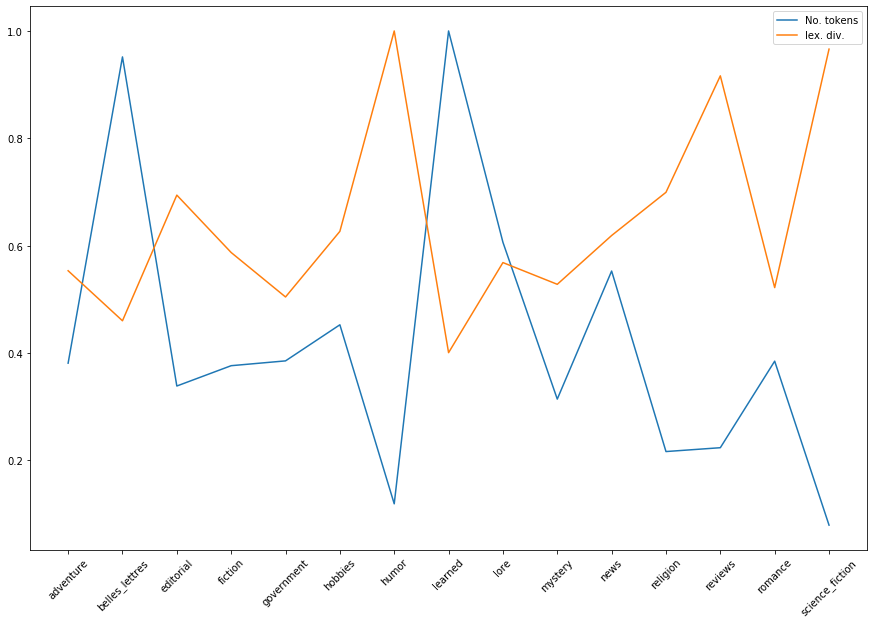

In [351]:
import matplotlib.pyplot as plt

tokens = []
lex_div = []

for c in brown.categories():
    tokens.append(len(brown.words(categories = c)))
    lex_div.append(lexical_diversity(brown.words(categories = c)))

# normalizing the arrays
tokens = [t/max(tokens) for t in tokens]
lex_div = [l/max(lex_div) for l in lex_div]

plt.figure(figsize = (15, 10))
plt.plot(tokens, label = "No. tokens")
plt.plot(lex_div, label = "lex. div.")
plt.legend()
plt.xticks(range(15), brown.categories(), rotation = 45)

plt.show()

*As you can see, the plots are almost exact inverses of each other: when one zigs, the other one zags.*

###### 17. 

◑ Write a function that finds the 50 most frequently occurring words of a text that are not stopwords.

In [6]:
from nltk.corpus import stopwords

def find_50_most_frequent_non_stopwords(text, lang = 'english'):
    stopwords = nltk.corpus.stopwords.words('english')
    fd = nltk.FreqDist(w.lower() for w in text if w.lower().isalpha() and w.lower() not in stopwords)
    return fd.most_common(50)

In [14]:
print(find_50_most_frequent_non_stopwords(brown.words()), end = '')

[('one', 3292), ('would', 2714), ('said', 1961), ('new', 1635), ('could', 1601), ('time', 1598), ('two', 1412), ('may', 1402), ('first', 1361), ('like', 1292), ('man', 1207), ('even', 1170), ('made', 1125), ('also', 1069), ('many', 1030), ('must', 1013), ('af', 996), ('back', 966), ('years', 950), ('much', 937), ('way', 908), ('well', 897), ('people', 847), ('little', 831), ('state', 807), ('good', 806), ('make', 794), ('world', 787), ('still', 782), ('see', 772), ('men', 763), ('work', 762), ('long', 752), ('get', 749), ('life', 715), ('never', 697), ('day', 687), ('another', 684), ('know', 683), ('last', 676), ('us', 675), ('might', 672), ('great', 665), ('old', 661), ('year', 658), ('come', 630), ('since', 628), ('go', 626), ('came', 622), ('right', 613)]

*All of the words look quite common, with the exception of 'af'.  To make sure this isn't an error, let's print up some sentences with 'af':*

In [15]:
i = 0
for s in brown.sents():
    if "Af" in s:
        if i < 10:
            print(' '.join(s))
        i += 1


water is Af and the H stands for hydrogen ; ;
Salt water is still Af , the same hydrogen is there .
Start with the right-hand piece `` B '' , Af , soldering it to the lower piece `` A '' of the same material but 12'' '' long .
Now lay 12 pieces of Af cut 5-3/4'' '' long side by side but separated by 12 pieces of the same material 1/2'' '' sq. .
Cap this assembly ( with spacing bars in place ) with a Af bar .
Now cut five Af locking bar spacers ( which run horizontally ) .
Position these using six intermediate temporary Af spacers and locate the upper 12'' '' bar `` A '' .
Cap with a Af bar and tack-solder in place .
Cap the locking bar spacers with two Af directly under the first two `` B '' pieces .
Now reassemble the frame , using Af roundhead steel screws and nuts .


*It looks like 'af' may be used in some scientific/math texts, as well as some texts in the hobby genre.*

###### 18. 

◑ Write a program to print the 50 most frequent bigrams (pairs of adjacent words) of a text, omitting bigrams that contain stopwords.

In [24]:
def most_freq_bigrams_wo_stopwords(text, n = 50, lang = 'english'):
    stopwords = nltk.corpus.stopwords.words(lang)
    bigrams = nltk.bigrams(w.lower() for w in text if w.lower().isalpha() and w.lower() not in stopwords)
    fd = nltk.FreqDist(bigrams)
    return fd.most_common(n)

In [26]:
most_freq_bigrams_wo_stopwords(brown.words())

[(('united', 'states'), 392),
 (('new', 'york'), 296),
 (('per', 'cent'), 146),
 (('years', 'ago'), 138),
 (('af', 'af'), 129),
 (('could', 'see'), 93),
 (('rhode', 'island'), 91),
 (('last', 'year'), 78),
 (('even', 'though'), 77),
 (('high', 'school'), 74),
 (('white', 'house'), 68),
 (('first', 'time'), 68),
 (('old', 'man'), 68),
 (('world', 'war'), 66),
 (('two', 'years'), 62),
 (('let', 'us'), 62),
 (('one', 'thing'), 60),
 (('fiscal', 'year'), 58),
 (('last', 'night'), 57),
 (('peace', 'corps'), 55),
 (('one', 'day'), 53),
 (('one', 'another'), 52),
 (('would', 'like'), 51),
 (('last', 'week'), 51),
 (('united', 'nations'), 49),
 (('new', 'england'), 49),
 (('young', 'man'), 47),
 (('los', 'angeles'), 47),
 (('two', 'men'), 46),
 (('one', 'two'), 43),
 (('great', 'deal'), 43),
 (('civil', 'war'), 42),
 (('president', 'kennedy'), 41),
 (('would', 'make'), 41),
 (('time', 'time'), 41),
 (('general', 'motors'), 41),
 (('small', 'business'), 41),
 (('long', 'time'), 40),
 (('new', '

######  19.
◑ Write a program to create a table of word frequencies by genre, like the one given in 1 for modals. Choose your own words and try to find words whose presence (or absence) is typical of a genre. Discuss your findings.

*It's not difficult to adapt the code used in the book to show the distribution of modals; but more difficult would be to generalize a function that could work with almost any collections of texts, since each collection may have a different way of organizing distinct genres.*

In [2]:
cfd = nltk.ConditionalFreqDist(
            (genre, word)
            for genre in brown.categories()
            for word in brown.words(categories = genre))

arts = ['the', 'a', 'an', 'this', 'that', 'these', 'those']
cfd.tabulate(conditions = brown.categories(), samples = arts)

                  the     a    an  this  that these those 
      adventure  3370  1354   159   203   494    28    27 
 belles_lettres  9726  3308   583   627  1896   224   113 
      editorial  3508  1095   184   259   578    63    57 
        fiction  3423  1281   156   147   530    40    30 
     government  4143   867   208   344   489   107    61 
        hobbies  4300  1737   226   305   514   101    63 
          humor   930   505    75    59   241    16    10 
        learned 11079  3215   695   714  1695   314   137 
           lore  6328  2304   364   354   984   122    75 
        mystery  2573  1136   125   146   494    17    25 
           news  5580  1993   300   250   802    59    58 
       religion  2295   655   119   217   475    66    42 
        reviews  2048   874   163   143   336    29    24 
        romance  2758  1335   152   149   583    30    53 
science_fiction   652   222    33    49   126    12     7 


In [9]:
cfd = nltk.ConditionalFreqDist(
            (genre, word)
            for genre in brown.categories()
            for word in brown.words(categories = genre))

advs = ['really', 'very', 'extremely', 'bit', 'absolutely', 'completely', 'literally', 'thoroughly', 'totally', 'utterly']
cfd.tabulate(conditions = brown.categories(), samples = advs)

                    really       very  extremely        bit absolutely completely  literally thoroughly    totally    utterly 
      adventure         18         41          0         11          1          7          0          1          0          3 
 belles_lettres         36        123          8          5          7         15          4          3          1          6 
      editorial         19         48          3          6          3          5          0          2          4          0 
        fiction         25         42          0          5          2          3          0          1          1          1 
     government          1         22          4          0          0          4          0          4          1          2 
        hobbies         14         63         10         15          1         13          4          9          2          1 
          humor          6         24          0          8          0          0          1          1        

*I chose to look at adverbs that can be used with gradable (e.g., 'tired') and ungradable (e.g., 'exhausted) adjectives.  The difference between the two is that gradable adjectives can be modified by words which express their scale - e.g., we can be 'a little tired', 'somewhat tired', 'really tired'; but ungradable adjectives cannot.  As a consequence, ungradable adjectives are often used with adverbs like 'absolutely', 'completely', 'thoroughly' (and also 'literally', though normally this usage would be considered incorrect).*

*Unsurprisingly, the adverbs used with gradable adjectives ('really', 'very', 'extremely', 'bit' - representing 'a bit') are much more common than the rest of the adverbs, which are used with ungradable adjectives.  Also surprising is how often adverbs like 'very' are used in 'belle lettres' and 'learned', genres which we'd usually suspect to have a more diverse lexicon.*

###### 20.

◑ Write a function `word_freq()` that takes a word and the name of a section of the Brown Corpus as arguments, and computes the frequency of the word in that section of the corpus.

In [14]:
from nltk.corpus import brown

def word_freq(word, genre):
    i = 0
    for w in brown.words(categories = genre):
        if w.lower() == word.lower():
            i += 1
            
    return i

In [15]:
word_freq("President", "news")

142

###### 21.

◑ Write a program to guess the number of syllables contained in a text, making use of the CMU Pronouncing Dictionary.

*While making this function I needed code that could convert a string or a nested list into a flat list.  As I ended up using this code often, I decided to encase it in a new function:*

In [377]:
def coerce_to_list(text):
    """
    Coerces nested list or string to a flat list.
    """
    
    # flatten nested lists
    if type(text[0]) == list:
        text = [i for s in text for i in s]
    # convert strings to lists
    elif type(text) == str:
        text = text.split(" ")
        
    return list(text)
    

In [378]:
def estimate_syllables(text):
    """
    Estimates the number of syllables in a text.  
    Text may be a list, a nested list, or a string.
    """
    cmu = nltk.corpus.cmudict.dict()
    total_syllables = 0
    
    text = coerce_to_list(text)
    
    for w in text:
        # only look up words, and ignore words not in cmu
        if w.isalpha() and w.lower() in cmu:
            # use the digits in the entires to calculate 
            # number of syllables
            for pron in (cmu[w.lower()][0]):
                for char in pron:
                    if char.isdigit():
                        total_syllables += 1
    return total_syllables

In [379]:
from nltk.corpus import gutenberg

print("{:,}".format(estimate_syllables(gutenberg.words('whitman-leaves.txt'))))

166,032


*My function will work with a list of words; a list of lists; or strings:*

In [380]:
from nltk.corpus import brown

print("{:,}".format(estimate_syllables(brown.words(categories = 'humor'))))

25,349


In [381]:
from nltk.corpus import brown

print("{:,}".format(estimate_syllables(brown.sents(categories = 'humor'))))

25,349


In [382]:
estimate_syllables("This is a test")

4

###### 22. 

◑ Define a function `hedge(text)` which processes a text and produces a new version with the word 'like' between every third word.

*I think the authors mean __after__ every third word.  For a group of linguists, the authors aren't especially articulate.*

*My code allows us to change the target word, as well as the interval where the new words will be inserted.  Further, it allows us to choose the output format: either a new string or a new list will be returned.*

*Finally, the code __literally__ inserts the target word after every $n$th word: it ignores punctuation and other non-alphabetic strings when it tallies where the new word should be inserted.*



In [383]:
def hedge(text, word, interval = 3, output = "string"):
    """
    Returns a modified version of a text with a specified word
    inserted at a designated interval.
    
    Arguments:
    
    text:     Text to be modified. Can be a list, nested list, or string.
    word:     Word to be inserted.  Must be a string.
    interval: After how many words should the target word be inserted? 
              Default value is three.
    output:   Output can be a new string or a new list.  Default is string.
    """
    
    text = coerce_to_list(text)
        
    if output == "string":
        
        newstring = ""
        i = 1
        for t in text:
            if t.isalpha() and i % interval == 0:
                newstring += t + " " + word + " "
                i += 1
            elif t.isalpha():    
                newstring += t + " "
                i += 1
            else:
                newstring += t + " "
        return newstring
    
    elif output == "list":
        
        newlist = []
        i = 1
        for t in text:
            if t.isalpha() and i % interval == 0:
                newlist.append(t)
                newlist.append(word)
                i += 1
            elif t.isalpha():    
                newlist.append(t)
                i += 1
            else:
                newlist.append(t)
        return newlist
    
    else:
        print("Sorry, the output can only be a string or a list.")
    

In [384]:
hedge("this is a test of a test for a test", "like")

'this is a like test of a like test for a like test '

In [385]:
print(hedge(brown.sents(categories = 'humor')[0:5], "like", output = "list"), end = '')

['It', 'was', 'among', 'like', 'these', 'that', 'Hinkle', 'like', 'identified', 'a', 'photograph', 'like', 'of', 'Barco', '!', '!', 'For', 'like', 'it', 'seems', 'that', 'like', 'Barco', ',', 'fancying', 'himself', 'like', 'a', "ladies'", 'man', '(', 'and', 'like', 'why', 'not', ',', 'after', 'like', 'seven', 'marriages', '?', '?', ')', ',', 'had', 'like', 'listed', 'himself', 'for', 'like', 'Mormon', 'Beard', 'roles', 'like', 'at', 'the', 'instigation', 'like', 'of', 'his', 'fourth', 'like', 'murder', 'victim', 'who', 'like', 'had', 'said', ':', '``', 'With', 'like', 'your', 'beard', ',', 'dear', 'like', ',', 'you', 'ought', 'to', 'like', 'be', 'in', 'movies', 'like', "''", '!', '!', 'Mills', 'secured', "Barco's", 'photograph', 'like', 'from', 'the', 'gentleman', 'like', 'in', 'charge', ',', 'rushed', 'like', 'to', 'the', 'Hollywood', 'like', 'police', 'station', 'to', 'like', 'report', 'the', 'theft', 'like', ',', 'and', 'less', 'than', 'like', 'five', 'minutes', 'later', 'like', ','

In [386]:
print(hedge(brown.words(categories = 'humor')[:120], "like", interval = 5), end = '')

It was among these that like Hinkle identified a photograph of like Barco ! ! For it seems that like Barco , fancying himself a ladies' man like ( and why not , after seven like marriages ? ? ) , had listed himself for like Mormon Beard roles at the like instigation of his fourth murder like victim who had said : `` With like your beard , dear , you ought like to be in movies '' ! ! Mills like secured Barco's photograph from the gentleman like in charge , rushed to the like Hollywood police station to report like the theft , and less than like five minutes later , detectives with like his picture in hand were like on the trail of Cal like Barco . On their way , they like stopped at 

###### 23. 

★ Zipf's Law: Let $f(w)$ be the frequency of a word $w$ in free text. Suppose that all the words of a text are ranked according to their frequency, with the most frequent word first. Zipf's law states that the frequency of a word type is inversely proportional to its rank (i.e. $f × r = k$, for some constant $k$). For example, the 50th most common word type should occur three times as frequently as the 150th most common word type.

* a. Write a function to process a large text and plot word frequency against word rank using `pylab.plot`. Do you confirm Zipf's law? (Hint: it helps to use a logarithmic scale). What is going on at the extreme ends of the plotted line?
    
* b. Generate random text, e.g., using `random.choice("abcdefg ")`, taking care to include the space character. You will need to import random first. Use the string concatenation operator to accumulate characters into a (very) long string. Then tokenize this string, and generate the Zipf plot as before, and compare the two plots. What do you make of Zipf's Law in the light of this?

*I first chose to do an analysis of "The Parent's Assistant" by Maria Edgeworth.  Using nltk `FreqDist` function, I was able to get the frequency distribution of the alphabetic strings in the text.*

In [135]:
ep = [w.lower() for w in gutenberg.words('edgeworth-parents.txt') if w.isalpha()]
fd = nltk.FreqDist(ep)

*Eyeballing the 50th and 150th most common words told me that Zipf's Law was roughly applicable here.  I.e. the 50th word, 'now', was 3.3 times as common as the 150th one, 'nothing'.*

In [136]:
fd.most_common(50)[-1]

('now', 508)

In [137]:
fd.most_common(150)[-1]

('nothing', 152)

*Getting the ranks and the counts for the plot involved some pretty convoluted line comprehensions, due to some idiosyncracies in Python syntax.  Firstly, `FreqDist` doesn't actually provide the numerical ranks, so I needed to use `enumerate` to generate those.  I also don't need the actual words from the distribution - only their frequencies - so at this point I can jettison them.  Since Python is zero-indexed, I have to add '1' to the enumeration, as I will use the log values of the ranks latter, and there is no log of zero.*

*At this point, I have a list of tuples, each of which has the rank and the counts.  To extract these values for my plot, I `zip` the values in my list, and assign them to the separate variables `ranks` and `counts`.*

In [156]:
ranks_counts = [(ranks + 1, counts) for ranks, counts in enumerate([counts for words, counts in fd.most_common(150)])]
ranks, counts = zip(*ranks_counts)

*Since I'd like to replicate this plot later, I encased everything in a function:*

In [404]:
import matplotlib.pyplot as plt

def plot_Zipf(text, title = '', scale = 'log', n = 150, plot_style = 'k-', reg_line = 'c--'):
    """
    Generates a plot showing word rank against
    word frequency. 
    
    Arguments:
    text:       May be a list, nested list, or string
    title:      Optional title for the resulting plot
    scale:      May be 'log' or 'linear'.  Default is 'log'
    n:          Number of words considered.  Default is 150.
    plot_style: Style of the scatter plots.  Default is a
                black line.
    reg_line:   Style of the regression line.  Default
                is cyan dashes.
    """
    plt.figure(figsize=(15, 10))
    
    # coerce text to list
    text = coerce_to_list(text)
    
    # create frequency distribution
    edited = [w.lower() for w in text if w.isalpha()]
    fd = nltk.FreqDist(edited)
    
    # extract the ranks and accompanying counts
    ranks_counts = [(ranks + 1, counts) for ranks, counts in enumerate([counts for words, counts in fd.most_common(n)])]
    ranks, counts = zip(*ranks_counts)  
    
    plt.xscale(scale)
    plt.yscale(scale)
    
    if scale == 'log':
        plt.xlabel('Word Ranking (logarithmic scale)')
        plt.ylabel('Word Counts (logarithimc scale)')
        
        # adding regression line for log scale
        logR = np.log(np.asarray(ranks))
        logC = np.log(np.asarray(counts))

        m, c = np.polyfit(logR, logC, 1)
        y_fit = np.exp(m * logR + c)

        plt.plot(ranks, y_fit, reg_line)      
        
    else:
        plt.xlabel('Word Ranking')
        plt.ylabel('Word Counts')
    
    # add title if necessary
    if len(title) != 0:
        plt.title('Zipf analysis of {}'.format(title))
    else:
        plt.title('Zipf analysis of text')

    plt.plot(ranks, counts, plot_style)
    plt.show()

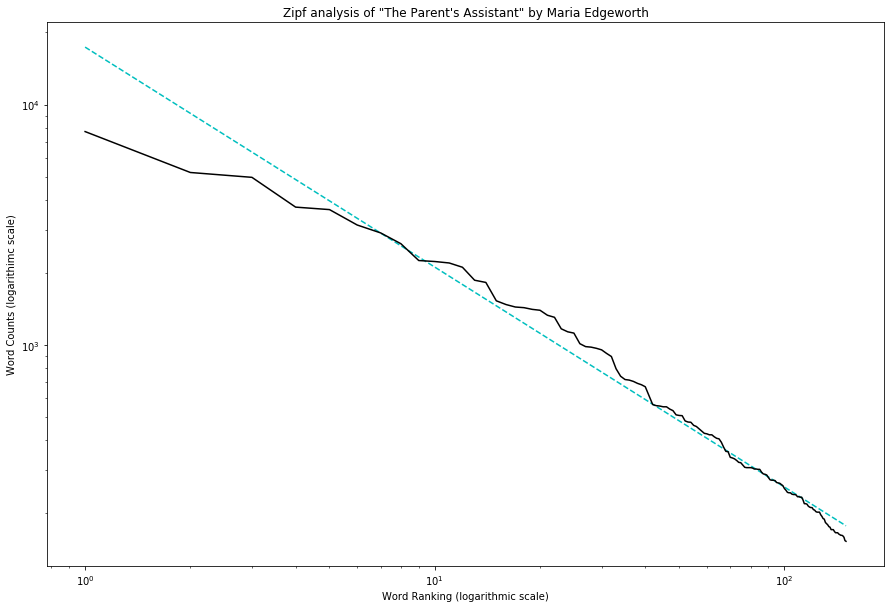

In [402]:
plot_Zipf(gutenberg.words('edgeworth-parents.txt'), title = '"The Parent\'s Assistant" by Maria Edgeworth', plot_style = 'k-')

*The plot basically shows what we'd expect: a roughly straight line when we plot the points on a logarithmic scale.  Let's a try a few more texts:*

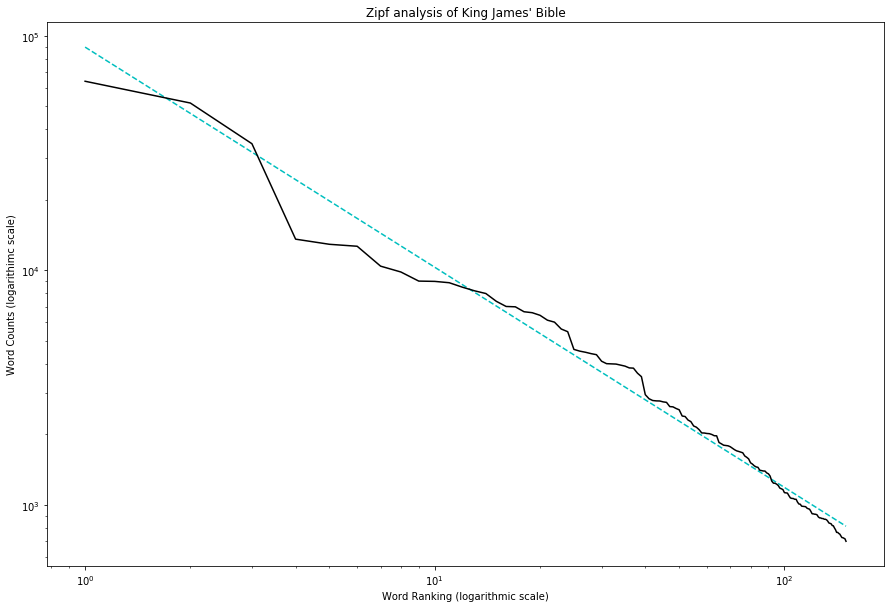

In [403]:
plot_Zipf(gutenberg.words('bible-kjv.txt'), title = 'King James\' Bible')

*The line seems a little jagged in places, but the overall trend is there.*

*With the collected texts in the Brown Corpus the plot is less linear, but again we can see the overall trend.*

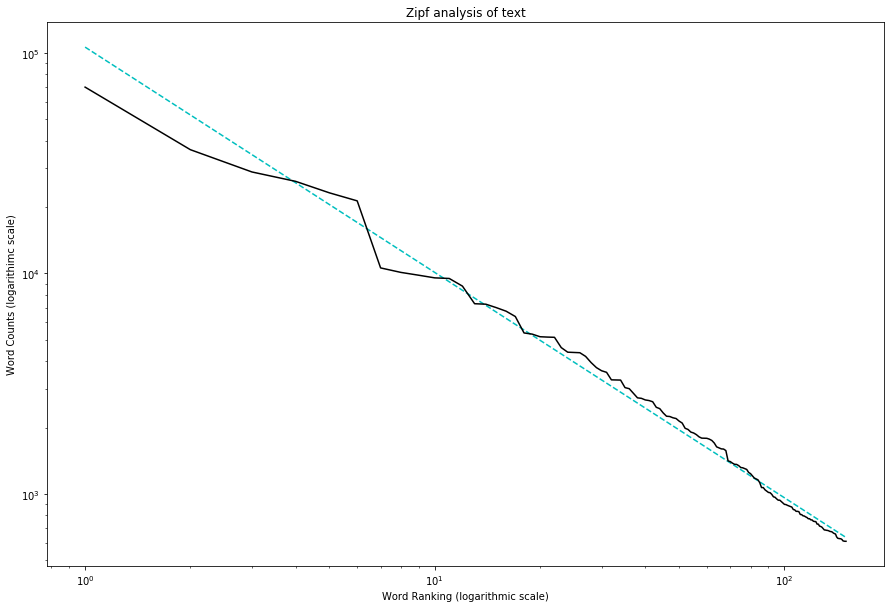

In [407]:
plot_Zipf(brown.sents())

*It will become much smoother if we increase the number of words analyzed.*

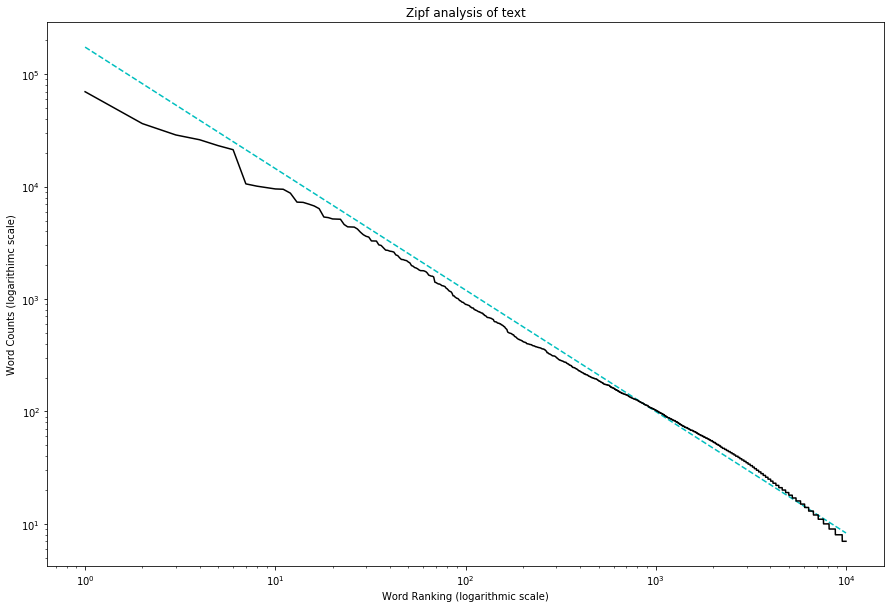

In [409]:
plot_Zipf(brown.sents(), n = 10000)

*Now we'll generate some random text for part B of this question:*

In [227]:
import random

test = ""

for i in range(5000000):
    test += random.choice("abcdefg ")


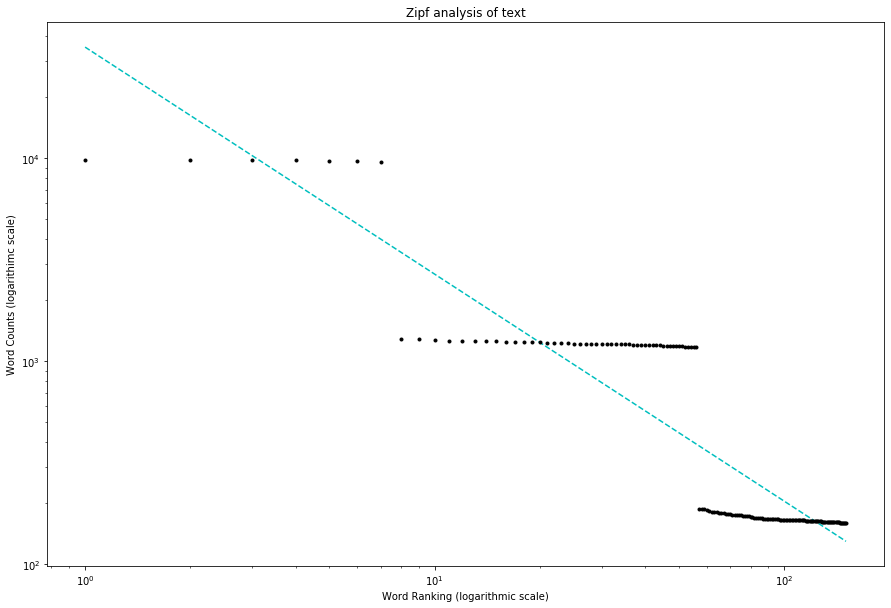

In [257]:
plot_Zipf(test)

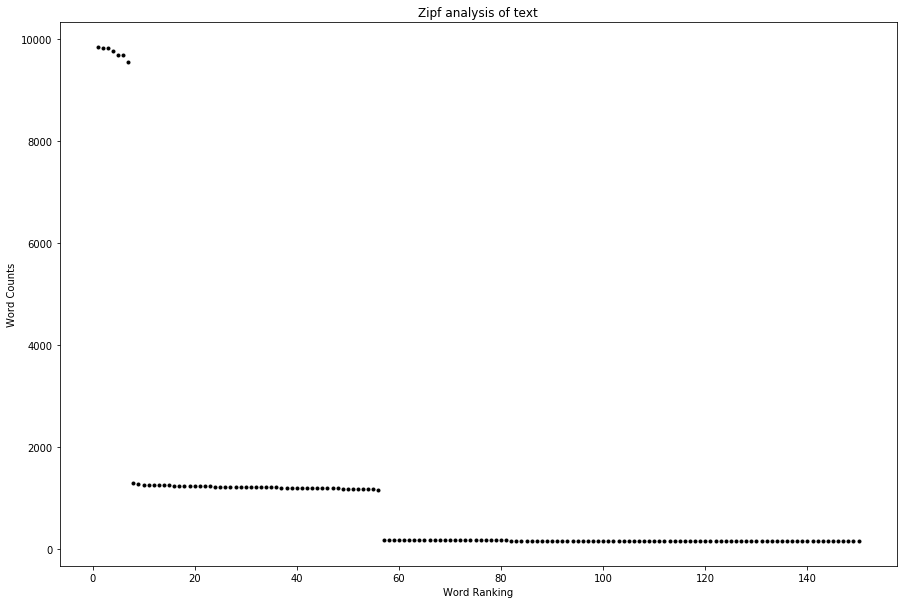

In [258]:
plot_Zipf(test, scale = "linear")

*The precise reasons why are beyond the scope of the book (it's a topic that large enough to be the subject of academic papers, cf. [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2834740/ "Zipf's law in random texts")), but the consensus seems to be that Zipf's Law does not apply for random texts.*

*Trying the test again, with all the letters of the alphabet and a larger text.*

In [268]:
import random

test2 = []

for i in range(80000000):
    test2.append(random.choice("abcdefghijklmnopqrstuvwxyz "))


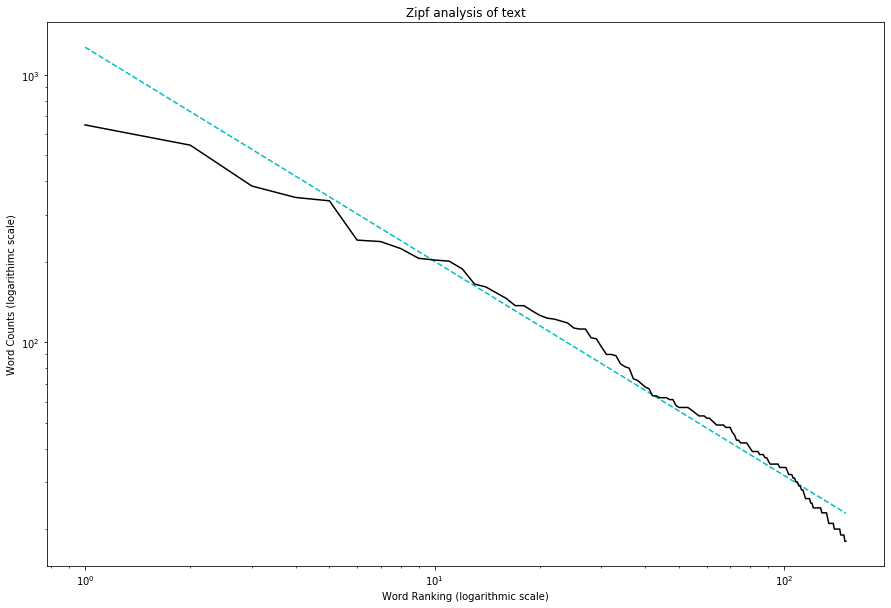

In [411]:
plot_Zipf(test2)

*With longer random texts, the distribution comes to resemble a Zipfian distribution.*


###### 24.

★ Modify the text generation program in [2.2](https://www.nltk.org/book/ch02.html#code-random-text "2.2") further, to do the following tasks:

* a. Store the $n$ most likely words in a list words then randomly choose a word from the list using `random.choice()`. (You will need to `import random` first.)
* b. Select a particular genre, such as a section of the Brown Corpus, or a genesis translation, one of the Gutenberg texts, or one of the Web texts. Train the model on this corpus and get it to generate random text. You may have to experiment with different start words. How intelligible is the text? Discuss the strengths and weaknesses of this method of generating random text.
* c. Now train your system using two distinct genres and experiment with generating text in the hybrid genre. Discuss your observations.

*As I noted in my notes for this chapter, the function in section 2.2 does not produce random text.  It is entirely deterministic, since the line `cfdist[word].max()` will always cause the function to choose the bigram with the highest frequency.  Therefore, if I use the exact same code as shown in the book, I should expect to get exactly the same result.*  

*To generate random text, I will have to use `random.choice()`; but `random.choice()` is not able to work on a `ConditionalFreqDist` unless we first isolate the `keys` and coerce them into a `list`.*

*I don't quite understand the point of part __a__ in the directions above.  It says we are to randomly choose a word from the $n$ most likely words in a text; but then it neglects to tell us what we should do with this word.  My assumption was that we should use this word to initialize a random text.  But in __b__ the instructions said we should experiment with different start words, which we can't do if we choose them randomly... Nonetheless, I like this idea of starting on a random word, so I built this functionality into my code.*



In [336]:
import random

def generate_random_text(text, num = 15, n = 50):
    """
    Uses a frequency distribution based upon a text to produce quasi-coherent
    random text.  Starting word is selected from a list of the n most common
    words in the text.
    
    Arguments:
    
    text: The text to be sampled from.  May be a string, list, or nested list.
    num:  The length in words of the string to be returned.
    n:    Size of the list of the nth most common words from which the 
          initial word is chosen.
    """
    # coerce to list
    text = coerce_to_list(text)
    
    # make a distribution of bigrams
    bigrams = nltk.bigrams(text)
    cfd = nltk.ConditionalFreqDist(bigrams)
    
    # create a list of the nth most likely words, and choose one to 
    # initialize the string of random words
    most_likely_words = nltk.FreqDist([w.lower() for w in text if w.isalpha()]).most_common(n)
    words, counts = zip(*most_likely_words)
    word = random.choice(words)
    
    # print out the current word, and randomly choose the subsequent word
    # from the cfd's keys
    for i in range(num):
        print(word, end = ' ')
        word = random.choice(list(cfd[word].keys()))
    

In [322]:
generate_random_text(nltk.corpus.genesis.words('english-kjv.txt'))

my sword and Bethuel , drink al and Kedemah : yea And Jared eight days 

In [332]:
generate_random_text(gutenberg.words('shakespeare-macbeth.txt'), num = 50)

what Greatnesse dedicate themselues , Noble Sir : Except they had I ' twould haue cause he slept , nor bad begun to trust them , Malcolm , loue the horrid Image doth know . Goe pronounce his Babes Sauagely slaughter on you where Conspirers are yet by Caesar . 

In [331]:
generate_random_text(brown.sents(categories = 'lore'), num = 50)

for reforms in State of purism ! Have no frustration with photographic realism of learning how representative is merely to flood of Jews in irons . Our community and Hoyt ) knew at $185 each grazin' bunch of motivation towards them are watching the airplanes came half full advantage to 

In [330]:
generate_random_text(brown.words(categories = 'news'), num = 50)

be chairman . R. L. Oliver is where modernization or sadism of Comus , Oliver G. Brown will provide $45 million . While in August Jack Kramer's professional career goes back along princesse skirt accented by their cases with geography or stole $150 from begging in front and charm . 

In [335]:
generate_random_text(brown.words(categories = ['humor', 'news', 'religion']), num = 50)

that historic at Indianapolis '' simply because individuals were treated for Mitchell Co. has sued for staffing the 10 dispatched earlier last fall 1961 Columbus track , prohibition , announce the flat lacked electricity . Doubts thus ending in which a couch on , raising the steam shovel . Following 

*The code is fun to play with, but there are some limitations: for one, we can only use bigrams.  The larger the size of the ngram, the more the text will resemble actual text.  Another limitation is the words are chosen at random, when we should actually be choosing more common words more frequently.*

*I believe I created a more useful set of functions to do this exact task when I was working my way through Allen Downey's [Think Python 2e](http://greenteapress.com/thinkpython2/html/thinkpython2014.html "Think Python Chapter 13").  My code uses dictionaries and Markov chains, neither of which have been so far in this book.  Although it's a bit more complex, it's still quite fast, and doesn't have the limitations of the code in chapter 2 of the NLTK book.*

*The complete code can be found in [my GitHub repo for my code for Think Python 2e](https://github.com/Sturzgefahr/ThinkPython/blob/master/Think%20Python%20-%20Chapter%2013/Think%20Python%20-%20Chapter%2013.ipynb "My code for Think Python 2e - Chapter 13").  The original code I wrote was designed to work on texts imported directly from the Project Gutenberg website.  This text is not tokenized and has lengthy legalese at the header and footer which has to be pruned before analysis.  I made a few alterations to the code so that it will work for the texts used here in the NLTK book:*

In [337]:
import os
path = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\ThinkPython"
os.chdir(path)

In [370]:
opened_text = open('alice.txt', 'r', encoding = "utf8")
alice = []
for line in opened_text:
    for word in line.split():
        alice.append(word.strip())

In [392]:
def make_ngram(array, index, n):
    """
    Returns a list of the n words following
    the word at the indexed point in the array.
    """
    ngram = []
    for j in range(1, n + 1):
        ngram.append(array[index + j])
    
    return ngram

def make_markov_dict(array, n):
    """
    Takes a list of words and returns a dictionary
    of all possible ngrams following each word in the array.
    """
    
    d = {}
    l = len(array)
    
    # adding padding so function doesn't crash at end of array
    array.extend(" " * n)
    
    for e in range(l):
        ngram = make_ngram(array, e, n)
        if array[e] not in d:
            d[array[e]] = ([ngram])
        else:
            d[array[e]] += ([ngram])
        
    # dictionary values for items at the end of the array
    # will have empty strings, and these need to be the
    # same size as the other values to prevent the code
    # from throwing an error
    
    d[" "] = " " * n
    return d

def minimarkov(d, word):
    """
    Randomly chooses one ngram from a Markov dictionary.
    """
    return(random.choice(d[word]))

def make_markov_text(text, n, length):
    """
    Takes a text, divides it into individual words, and the makes 
    a Markov dict for each word and all possible ngrams that
    follow it.  Then a word is randomly chosen, and of the ngrams
    that followed that word in the text, one is selected and 
    concatenated to the new text.  New text is printed.
    
    Arguments:
    text: a raw text 
    n: length of ngrams, i.e., words that occur together
        in the text.  The higher n, the more natural the 
        resulting text.
    length: number of ngrams to be concatenated. Length of final
        text will be 1 + n * length.
    """
    
    if type(text) != list:
        text = coerce_to_list(text)
        
    d = make_markov_dict(text, n)
    start = random.choice(list(d.keys()))
    markov_text = [start]
    
    for i in range(length):
        markov_text.extend(minimarkov(d, markov_text[-1]))
    for word in markov_text:
        print(word, end = " ")

In [393]:
make_markov_text(alice, 2, 20)

LIKE it.’ Which Alice did so. ‘It’s my own invention--to keep straight on one side,’ Alice added. ‘Exactly so. Well, then, the books to the noise seemed quite full of hay!’ Haigha took hours and clear; I can’t tell you, if 

In [372]:
make_markov_text(alice, 3, 20)

head: at last it yesterday--my nice new way of getting as dark as she arranged a melancholy voice; and mouth; and when they wake up into a smile lighting up his brother: ‘but you like,’ said the more I walk with us!” The last word ended in his rolling it up and I’ve pinned it saves time.’ Alice said, a little 

In [373]:
make_markov_text(alice, 4, 20)

‘but I suppose it will only tell me the crime comes last of voices joined in the other paw she rubbed it with his thumb, as if he were clean and neat-- And if I hold it again. ‘Take care!’ cried the Queen. ‘Why, don’t go on like that!’ Alice hastily said, hoping to cheer him up, ‘if I don’t make when they tumble! Just look along the road, and tell me if she had got some of them--particularly verbs, they’re 

In [394]:
make_markov_text(alice, 5, 20)

die away, till all was dead silence, and Alice lifted up the large hall, and noticed this, there were so many things.’ ‘Fan her head!’ the shovel--and here are two castles walking arm in arm--I don’t care about the colour,’ the twig, and, as she was a little wide of the ways about here belong to keep him from beginning. ‘The prettiest are always further!’ she spoke, and a sudden gust of wind blew the Queen’s shawl across a little brook. ‘I declare it’s marked out his hand to the Messenger said, peeping into the bag. ‘Hay, then,’ the King murmured 

In [395]:
make_markov_text(gutenberg.words('shakespeare-macbeth.txt'), 2, 20)

caution , thanks Both sides , towards him . With this starting Doct . Heark , she rubbes her the meanes : Then ' tis truly ow ' d out in the desert ayre , The which he auouches , do 

In [398]:
make_markov_text(brown.words(), 4, 20)

skies turn dark but the Secretary of the Treasury the total cost of dollars or to `` I got my release . All this , scarecrowish figure in the Deller Consort could be determined individually . What it does : Prevents and treats acetonemia ( and subsequent facts bear he was , with my own wife . In any event Rector said . `` I know this from my finger and let us , ready-made . We've never been refused ! 

In [399]:
make_markov_text(brown.sents(), 5, 20)

coachman and Delphine were gaining on . This is not true -- authenticity and realism often enough , so that the legend goes , someone put aside desires and perturbations so that the program can be built for the first time , there having been a small table on which she was clean now for his women where he finds them -- have taken organized form the quotation marked `` public preaching and from 20 to this Mecca of the beat around the buoys in dozens of frostbite races . Some elements support the others , yes , but important . 

###### 25. 

★ Define a function `find_language()` that takes a string as its argument, and returns a list of languages that have that string as a word. Use the `udhr` corpus and limit your searches to files in the Latin-1 encoding.

*The function is cute, but considering how short the Universal Declaration of Human Rights is, it's not very useful for this sort of task...*

In [428]:
from nltk.corpus import udhr

def find_language(word):
    latin1_langs = [l for l in udhr.fileids() if l.endswith('Latin1')]
    matches = []
    for l in latin1_langs:
        if word in udhr.words(l):
            matches.append(l[:-7])
            
    return matches

In [430]:
print(find_language('man'), end = '')

['Bichelamar', 'Bikol_Bicolano', 'Cakchiquel', 'Chamorro', 'Chuuk_Trukese', 'English', 'Friulian_Friulano', 'Hiligaynon', 'Ibibio_Efik', 'Iloko_Ilocano', 'Kapampangan', 'Kiche_Quiche', 'Luxembourgish_Letzebuergeusch', 'Mam', 'Marshallese', 'NigerianPidginEnglish', 'Sharanahua', 'SolomonsPidgin_Pijin', 'Tiv', 'TokPisin', 'Trukese_Chuuk', 'Waray']

In [437]:
print(find_language('and'), end = '')

['Albanian_Shqip', 'Bemba', 'Cebuano', 'English', 'NigerianPidginEnglish', 'Romani']

###### 26. 
★ What is the branching factor of the noun hypernym hierarchy? I.e. for every noun synset that has hyponyms — or children in the hypernym hierarchy — how many do they have on average? You can get all noun synsets using `wn.all_synsets('n')`.

*I found the question to be a little bit confusing: in the beginning they asked for the branching factor of hypernyms; but later they seemed to be asked for the branching facter of hyponyms.  However, it makes sense in the end, since the two numbers are the same.  I.e., the number of branches (or edges, if we're looking at it as a network) will be the same whether we look from the top down or from the bottom up.*

In [460]:
from nltk.corpus import wordnet as wn

l = list(wn.all_synsets('n'))

hypo_branches = []
for i in l:
    hypo_branches.append(len(i.hyponyms()))

sum(hypo_branches)/len(hypo_branches)

0.9237045606770992

In [459]:
hyper_branches = []
for i in l:
    hyper_branches.append(len(i.hypernyms()))
sum(hyper_branches)/len(hyper_branches)

0.9237045606770992

###### 27. 

★ The polysemy of a word is the number of senses it has. Using WordNet, we can determine that the noun dog has 7 senses with: `len(wn.synsets('dog', 'n'))`. Compute the average polysemy of nouns, verbs, adjectives and adverbs according to WordNet.

In [483]:
wn.synsets('dog', 'n')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01')]

In [477]:
len(wn.synsets('dog', 'n'))
    

7

In [488]:
from itertools import islice
for synset in islice(wn.all_synsets('n'), 15):
    print(synset, len(synset.definition()))

Synset('entity.n.01') 101
Synset('physical_entity.n.01') 37
Synset('abstraction.n.06') 77
Synset('thing.n.12') 36
Synset('object.n.01') 63
Synset('whole.n.02') 58
Synset('congener.n.03') 67
Synset('living_thing.n.01') 32
Synset('organism.n.01') 85
Synset('benthos.n.02') 71
Synset('dwarf.n.03') 42
Synset('heterotroph.n.01') 68
Synset('parent.n.02') 66
Synset('life.n.10') 26
Synset('biont.n.01') 32


answer may be here https://stackoverflow.com/questions/46537372/compute-the-average-polysemy-of-nouns-verbs-adjectives-and-adverbs-according-t

or here
https://stackoverflow.com/questions/16523380/polysemy-count-return-senses-rather-than-of-senses-wordnet-nltk